In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

from scipy.stats import norm, expon, gamma, chi2, chisquare, chi2_contingency, \
    randint, kstest, poisson, binom, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint  

sns.set()

# Критерий Манна-Уитни

Мы снова решаем задачу однородности
$$H_0: F = G$$
$$H_1: F \neq G$$
где $F$ и $G$ - функции распределения св, из которых сэмплированы две выборки

In [9]:
distr_a = norm(0, 1)
distr_b = norm(2, 1)

X, Z = distr_a.rvs(50), distr_a.rvs(50)
Y = distr_b.rvs(50)

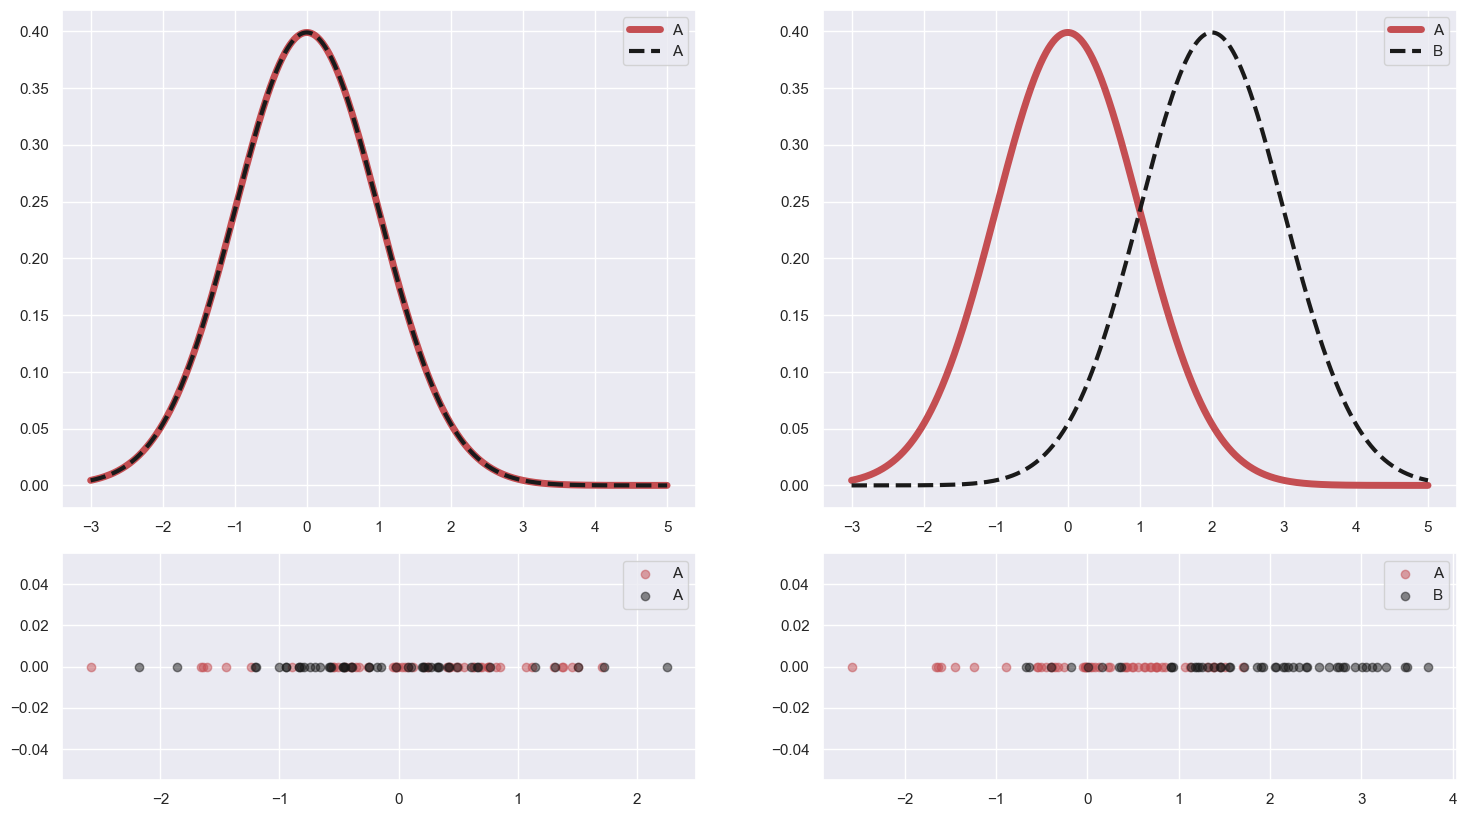

In [14]:
x = np.linspace(-3, 5, 1000)

fig = plt.figure(figsize=(18, 10))

gs = plt.GridSpec(3, 2)

ax00 = fig.add_subplot(gs[0:2, 0])
ax10 = fig.add_subplot(gs[2, 0])
ax01 = fig.add_subplot(gs[0:2, 1])
ax11 = fig.add_subplot(gs[2, 1])

ax00.plot(x, distr_a.pdf(x), label='A', c='r', lw=5)
ax00.plot(x, distr_a.pdf(x), linestyle='--', c='k', label='A', lw=3)
ax00.legend()

ax10.scatter(X, [0] * len(X), c='r', alpha=0.5, label='A')
ax10.scatter(Z, [0] * len(X), c='k', alpha=0.5, label='A')
ax10.legend()

ax01.plot(x, distr_a.pdf(x), label='A', c='r', lw=5)
ax01.plot(x, distr_b.pdf(x), linestyle='--', c='k', label='B', lw=3)
ax01.legend()

ax11.scatter(X, [0] * len(X), c='r', alpha=0.5, label='A')
ax11.scatter(Y, [0] * len(X), c='k', alpha=0.5, label='B')
ax11.legend()

Видим, что когда распределения отличаются сдвигом, выборка тоже получается сдвинутой, и одна из них правее другой. Давайте в качестве статистики будем считать количество таких вот пар точек из разных распределений, для которого точка из второго распред правее чем из первого. Статистика выглядит тогда вот так  

$$
\begin{align}
    U = \sum_{i}^N\sum_{j}^M [A_i < B_j]
\end{align}
$$

где $A_1, ..., A_N$ &mdash; первая выборка, $B_1, ..., B_M$ &mdash; вторая выборка, $[...]$ &mdash; функция-индикатор, которая равна 1, если выполнено условие в скобках, и 0 иначе.

Отменим, без доказательства, что есть алгоритм высчитывания этой статистики не за $O(NM)$, а за $O((N+M)log(N+M))$

In [15]:
def mann_whitney_statistic(x, y):
    """
    Вычисляет статистику критерия Манна-Уитни для двух независимых выборок.

    Параметры:
    x (numpy.ndarray): Первая выборка.
    y (numpy.ndarray): Вторая выборка.

    Возвращает:
    U (float): Статистика критерия Манна-Уитни.
    """
    # Объединяем две выборки в одну
    combined = np.concatenate((x, y))

    # Вычисляем ранги объединенной выборки
    ranks = np.argsort(np.argsort(combined)) + 1

    # Вычисляем сумму рангов для каждой выборки
    rank_sum_x = np.sum(ranks[:len(x)])
    rank_sum_y = np.sum(ranks[len(x):])

    # Вычисляем статистику критерия Манна-Уитни
    U = rank_sum_x - len(x) * (len(x) + 1) / 2

    return U

Как обычно, попытаемся понять распределение статистики

In [26]:
N_expr = 10000

distr_a = norm(0, 1)
distr_b = norm(2, 1)

sample_a_size = 100
sample_b_size = 80

stat = np.empty(N_expr)

for i in tqdm(range(N_expr)):
    stat[i] = mann_whitney_statistic(distr_a.rvs(sample_a_size), distr_b.rvs(sample_b_size))

100%|██████████| 10000/10000 [00:01<00:00, 8626.53it/s]


<Axes: ylabel='Density'>

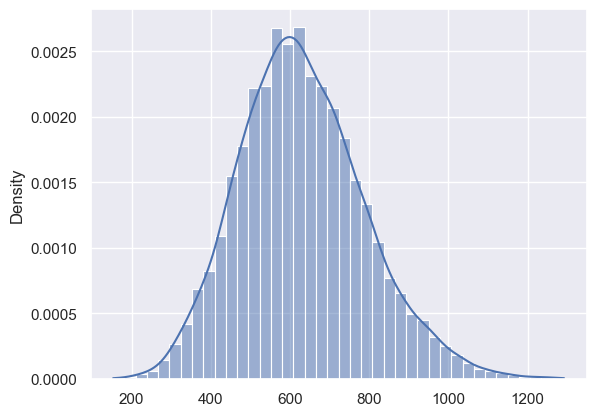

In [27]:
fig, ax = plt.subplots()

sns.histplot(stat, ax=ax, kde=True, stat='density', bins=40)

Видим, что распределение очень похоже на нормальное, что подтверждается следующей теоремой:   
- Если $A$ и $B$ одинаковые абсолютно непрерывные распределения имеет место следующее поведение статистики $U$ на бесконечности 
$$
U \overset{d}\rightarrow \mathcal{N}(\mathbb{E}U, \mathbb{D}U), \text{ где}\\
\mathbb{E} U = \dfrac{NM}{2},\\
\mathbb{D}U = \dfrac{NM(N + M + 1)}{12}
$$

Непрерывность используется для того чтобы вероятность совпадения двух значений была нулевая, что не верно для дискретных распределений, для которых используется другая статистика $$U = \sum_{i}^N\sum_{j}^M I[A_i < B_j] + \sum_{i}^N\sum_{j}^M \dfrac{1}{2}I[A_i = B_j]$$   
С соответствующими поправками к формулам для матожа и дисперсии

Как я понял, в scipy функции уже раелизована поправка для дискретных распределений, поэтому для них он работает корректно

In [28]:
def check_mannwhitneyu(dist1, dist2, sample1_size, sample2_size, alpha=0.05, N_exps=10_000, alternative='two-sided'):
    positive = 0

    for i in tqdm(range(N_exps), leave=False):
        sample1 = dist1.rvs(sample1_size)
        sample2 = dist2.rvs(sample2_size)

        pval = mannwhitneyu(sample1, sample2, alternative=alternative).pvalue

        positive += (pval < alpha)

    rate = positive / N_exps
    left, right = proportion_confint(count = positive, nobs = N_exps, alpha=alpha, method='wilson')

    return rate, left, right

In [12]:
fpr, left, right = check_mannwhitneyu(
    dist1=norm(),
    dist2=norm(),
    sample1_size=30,
    sample2_size=20
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.049
FPR confint:  (0.044939516707863926, 0.053406849822486356)


In [11]:
fpr, left, right = check_mannwhitneyu(
    dist1=expon(3),
    dist2=expon(3),
    sample1_size=30,
    sample2_size=20
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0503
FPR confint:  (0.04618626511967923, 0.05475910301490729)


In [13]:
fpr, left, right = check_mannwhitneyu(
    dist1=gamma(2),
    dist2=gamma(2),
    sample1_size=30,
    sample2_size=20
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0525
FPR confint:  (0.04829793395796121, 0.05704574458379433)


In [16]:
fpr, left, right = check_mannwhitneyu(
    dist1=randint(1, 6),
    dist2=randint(1, 6),
    sample1_size=30,
    sample2_size=20
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0467
FPR confint:  (0.042735761876580645, 0.05101237104627474)


Видим корректную работу в случае верности нулевой гипотезы

In [22]:
tpr, left, right = check_mannwhitneyu(
    dist1=norm(0.5, 1),
    dist2=norm(0, 1),
    sample1_size=100,
    sample2_size=90
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.9182
TPR confint:  (0.912666569988364, 0.9234122537744021)


In [24]:
tpr, left, right = check_mannwhitneyu(
    dist1=randint(1, 6),
    dist2=randint(3, 6),
    sample1_size=100,
    sample2_size=90
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.9993
TPR confint:  (0.9985556655587302, 0.9996608736683119)


Корректно работает для сдвинутых данных, а что с растянутыми?

In [25]:
tpr, left, right = check_mannwhitneyu(
    dist1=norm(0, 3),
    dist2=norm(),
    sample1_size=100,
    sample2_size=90
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.0643
TPR confint:  (0.05965779150234358, 0.069276824677864)


Если внимательно посмотреть на формулу, то такой результат становится ожидаемым, мощность довольно плоха

Поэтому, было бы правильнее переписать гипотезу, которую проверяет критерий Манна-Уитни   
$$H_0: \mathbb{P}(A < B) = \mathbb{P}(A > B) \\ vs \\ H_1:\mathbb{P}(A < B) \neq \mathbb{P}(A > B)$$

Или, альтернатива может быть не со значком $\neq$, а со значками $>$ или $<$

То есть одна выборка правее или левее другой (что не интуитивно понятная вещь, как покажут дальнейшие примеры)

Для проверки альтернативы с $>$ или $<$  в scipy функции реализован аргумент alternative

In [29]:
tpr, left, right = check_mannwhitneyu(
    dist1=norm(1, 1),
    dist2=norm(0, 1),
    sample1_size=100,
    sample2_size=90,
    alternative='greater'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  1.0
TPR confint:  (0.9996160016293234, 1.0)


In [30]:
tpr, left, right = check_mannwhitneyu(
    dist1=norm(1, 1),
    dist2=norm(0, 1),
    sample1_size=100,
    sample2_size=90,
    alternative='less'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.0
TPR confint:  (0.0, 0.0003839983706765959)


Видим, что это функция работает корректно, теперь немного посмотрим на примеры, когда непонятно какое распределение левее

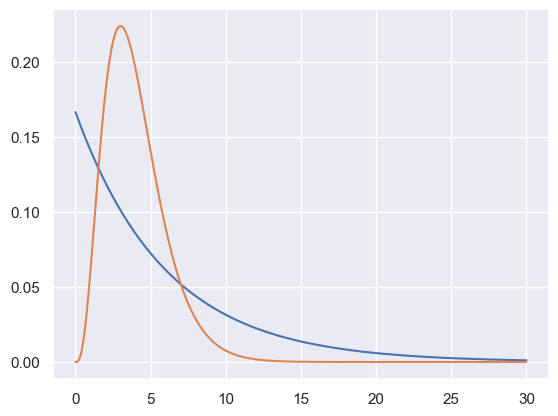

In [79]:
dist1 = expon(loc=0, scale=6)
dist2 = gamma(a=4, scale=1)
x = np.linspace(0, 30, 1000)

fig, ax = plt.subplots()
ax.plot(x, dist1.pdf(x))
ax.plot(x, dist2.pdf(x))

По рисунке не ясно какое из распределений правее, что думает на этот счёт Манн и Уитни?

In [81]:
tpr, left, right = check_mannwhitneyu(
    dist1=dist1,
    dist2=dist2,
    sample1_size=1000,
    sample2_size=1000,
    alternative='less'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.0
TPR confint:  (0.0, 0.0003839983706765959)


In [82]:
tpr, left, right = check_mannwhitneyu(
    dist1=dist1,
    dist2=dist2,
    sample1_size=1000,
    sample2_size=1000,
    alternative='greater'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.9173
TPR confint:  (0.9117401216863086, 0.9225393932735246)


Говорит, что на картинке экспоненциальное распределение правее, чем гамма, а если немножко поменять картинку?

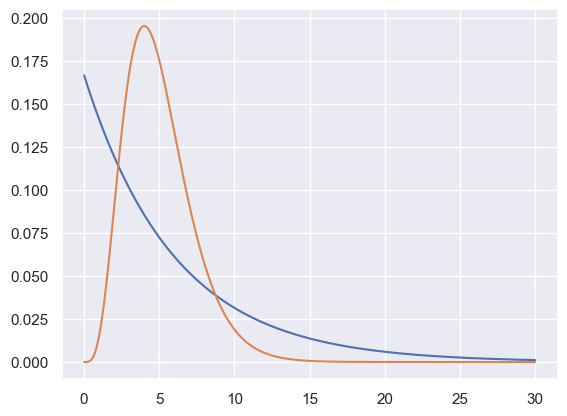

In [83]:
dist1 = expon(loc=0, scale=6)
dist2 = gamma(a=5, scale=1)
x = np.linspace(0, 30, 1000)

fig, ax = plt.subplots()
ax.plot(x, dist1.pdf(x))
ax.plot(x, dist2.pdf(x))

In [84]:
tpr, left, right = check_mannwhitneyu(
    dist1=dist1,
    dist2=dist2,
    sample1_size=1000,
    sample2_size=1000,
    alternative='less'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.8845
TPR confint:  (0.8780872925872064, 0.8906174126657432)


In [85]:
tpr, left, right = check_mannwhitneyu(
    dist1=dist1,
    dist2=dist2,
    sample1_size=1000,
    sample2_size=1000,
    alternative='greater'
)
print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.0
TPR confint:  (0.0, 0.0003839983706765959)


Теперь результат противоположный

Это всё показывает насколько спецефичен критерий Манна-Уитни, и его результат очень тяжело проинтерпретировать - нулевая гипотеза не говорит нам ничего о распределении, кроме того что в ней написано (из этого никак не вывести то, что равны средние распределений или медианы), да и альтернатива во всех её постановка не имеет смысла в общем случае

Так что критерий нужно использовать аккуратно, к примеры если мы знаем что наши распределения нормальны то альтернатива ясно отрицает равенство средних, поэтому нужно думать прежде чем делать :)